In [19]:

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pydicom


import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

from dataset import CTDataset
#from logger import Logger
from loss import DiceLoss
from unet import UNet

In [20]:

import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

from train import *

c:\Users\Haimo Dong\Desktop\gg2_python
c:\Users\Haimo Dong\Desktop\gg2_python\unet\model\epoch200_test_model.pth
(128, 128)
(1, 128, 128)


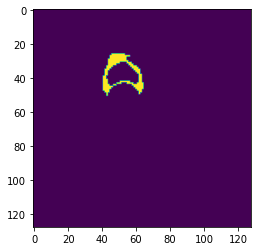

In [46]:
roots = os.path.split(os.getcwd())
root = roots[0]
model_path = os.path.join(root, 'unet\\model\\epoch200_test_model.pth')
mask_folder_path = os.path.join(root, 'data\\train\\mask')
image_folder_path = os.path.join(root, 'data\\train\\image')
pred_folder_path = os.path.join(root, 'data\\prediction')

print(root)
print(model_path)

test_path = os.path.join(root, 'data\\train\\mask\\z_mask045.txt')
xxx = np.loadtxt(test_path)
#plt.imshow(xxx)
print(xxx.shape)
y = np.expand_dims(xxx, axis=0)
print(y.shape)
plt.imshow(y[0])
mask_folder_path = os.path.join(root, 'data\\train\\mask')
image_folder_path = os.path.join(root, 'data\\train\\image')



In [22]:
model = torch.load(model_path)
model.eval()
device = torch.device("cpu" if not torch.cuda.is_available() else 'cuda')
model.to(device)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [23]:
CT_dataset = CTDataset(image_folder_path, mask_folder_path)

loader_train, loader_valid = data_loaders(CT_dataset, CT_dataset)

In [42]:
'''
for i, data in enumerate(loader_train):

    x, y_true = data
    x, y_true = x.to(device), y_true.to(device)
    y_pred = model(x)
    batch_size = x.shape[0]
    print(x.shape)
    
    for j in range(batch_size):
        image, mask, pred_mask = x[j][0].cpu().detach().numpy(), y_true[j][0].cpu().detach().numpy(), y_pred[j][0].cpu().detach().numpy(), 
        
        plt.figure(figsize=(15, 15))
    
        # plot 3 orthogonal slices
        a1 = plt.subplot(2, 2, 1)
        plt.imshow(image)
    

        a2 = plt.subplot(2, 2, 2)
        plt.imshow(mask)


        a3 = plt.subplot(2, 2, 3)
        plt.imshow(pred_mask)

        
        plt.show()
    #print(x[0].shape, y_true.shape, y_pred.shape
    '''


'\nfor i, data in enumerate(loader_train):\n\n    x, y_true = data\n    x, y_true = x.to(device), y_true.to(device)\n    y_pred = model(x)\n    batch_size = x.shape[0]\n    print(x.shape)\n    \n    for j in range(batch_size):\n        image, mask, pred_mask = x[j][0].cpu().detach().numpy(), y_true[j][0].cpu().detach().numpy(), y_pred[j][0].cpu().detach().numpy(), \n        \n        plt.figure(figsize=(15, 15))\n    \n        # plot 3 orthogonal slices\n        a1 = plt.subplot(2, 2, 1)\n        plt.imshow(image)\n    \n\n        a2 = plt.subplot(2, 2, 2)\n        plt.imshow(mask)\n\n\n        a3 = plt.subplot(2, 2, 3)\n        plt.imshow(pred_mask)\n\n        \n        plt.show()\n    #print(x[0].shape, y_true.shape, y_pred.shape\n    '

In [48]:
pred_mask3d = []

for image_name in os.listdir(image_folder_path):
    image_path = os.path.join(image_folder_path, image_name)
    image = np.loadtxt(image_path)
    image = np.expand_dims(image, axis=0)
    image = torch.tensor(np.expand_dims(image, axis=0), dtype=torch.float32)
    image = image.to(device)
    
    mask_pred = model(image)
    mask_pred = mask_pred.cpu().detach().numpy()[0][0]

    pred_mask3d.append(mask_pred)
    save_path = os.path.join(pred_folder_path, 'pred_' + image_name)
    np.savetxt(save_path, mask_pred)
    #plt.imshow(mask_pred)

pred_mask3d = np.array(pred_mask3d)

In [20]:
from skimage.measure import marching_cubes_lewiner
import meshplot as mp
from stl import mesh

In [21]:
vertices,faces,_,_ = marching_cubes_lewiner(pred_mask3d)
mp.plot(vertices, faces, return_plot=False)

def dataToMesh(vert, faces):
    mm = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
    for i, f in enumerate(faces):
        for j in range(3):
            mm.vectors[i][j] = vert[f[j],:]
    return mm

mm = dataToMesh(vertices, faces)
mm.save('test_a_scan.stl')

C:\Users\HAIMOD~1\AppData\Local\Temp/ipykernel_6176/1897982135.py:1: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices,faces,_,_ = marching_cubes_lewiner(mask3d)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(36.5, 50.…